# ADA442 Project - Bank Term Deposit Subscription Prediction Model Training

This analysis explores a bank marketing campaign dataset to identify factors influencing term deposit subscriptions and develop a predictive model to optimize future campaigns. The dataset includes client demographics, banking history, campaign details, economic indicators, and subscription outcomes. The bank aims to increase marketing efficiency by targeting customers with higher subscription probability.

The dataset "bank-additional.csv" contains:
* Client demographics (age, job, marital status, education)
* Banking relationship data (default status, housing/personal loans)
* Campaign contact information (communication type, previous contacts)
* Economic indicators (employment variation rate, consumer price index)
* Target variable: term deposit subscription (yes/no)


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('bank-additional.csv', sep=';')

# 1. Data Cleaning

## dataset overview

In [3]:
# 1. Dataset Shape (Full dataset)
print("Dataset shape:", df.shape)

# 2. Missing Values per Column
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# 3. Descriptive Statistics
# Display only the first few rows of the descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())

# 4. Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical Variables:")
print(categorical_cols)

# 5. Numerical Variables
numerical_cols = df.select_dtypes(include=['number']).columns
print("\nNumerical Variables:")
print(numerical_cols)

print("Total duplicates:")
print(df.duplicated().sum())

print("Target distribution:")
print(df['y'].value_counts())

Dataset shape: (4119, 21)

Missing values per column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Descriptive Statistics:
               age     duration     campaign        pdays     previous  \
count  4119.000000  4119.000000  4119.000000  4119.000000  4119.000000   
mean     40.113620   256.788055     2.537266   960.422190     0.190337   
std      10.313362   254.703736     2.568159   191.922786     0.541788   
min      18.000000     0.000000     1.000000     0.000000     0.000000   
25%      32.000000   103.000000     1.000000   999.000000     0.000000   
50%      38.000000   181.000000     2.000000

## inconsistency check

In [4]:
# Check for inconsistencies in unique values for each column
for col in df.columns:
    unique_vals = df[col].unique()
    if len(unique_vals) < 10:  # Display unique values only for columns with less than 10 unique values
        print(f"\nUnique values for column '{col}':")
        print(unique_vals)
    else:
        print(f"\nColumn '{col}' has {len(unique_vals)} unique values (too many to display).")

    # Example inconsistency check (you might need to adjust this based on your data):
    if col == 'job':  # Example column to check, replace 'job' as needed
        if 'unknown' in unique_vals:
            print("Inconsistency found: 'unknown' value present in 'job' column.")




Column 'age' has 67 unique values (too many to display).

Column 'job' has 12 unique values (too many to display).
Inconsistency found: 'unknown' value present in 'job' column.

Unique values for column 'marital':
['married' 'single' 'divorced' 'unknown']

Unique values for column 'education':
['basic.9y' 'high.school' 'university.degree' 'professional.course'
 'basic.6y' 'basic.4y' 'unknown' 'illiterate']

Unique values for column 'default':
['no' 'unknown' 'yes']

Unique values for column 'housing':
['yes' 'no' 'unknown']

Unique values for column 'loan':
['no' 'unknown' 'yes']

Unique values for column 'contact':
['cellular' 'telephone']

Column 'month' has 10 unique values (too many to display).

Unique values for column 'day_of_week':
['fri' 'wed' 'mon' 'thu' 'tue']

Column 'duration' has 828 unique values (too many to display).

Column 'campaign' has 25 unique values (too many to display).

Column 'pdays' has 21 unique values (too many to display).

Unique values for column 'pre

## handling unknown entries

In [5]:
# Replace 'unknown' values in categorical columns with the most common value for each column

for col in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
    most_common = df[col].mode()[0]
    df[col] = df[col].replace('unknown', most_common)

# 2. Feature Engineering

In [6]:
# Create binary feature for previous contact and drop original pdays column

df['has_contacted'] = df['pdays'].apply(lambda x: 1 if x != 999 else 0)
df = df.drop(columns=['pdays'])

In [7]:
# ratio to see if the person mostly contacted on the past or now (to see if the campaing fatigue)
df['contact_count_ratio'] = df['previous'] / (df['campaign'] + 1)

In [8]:
# defining categorical and numerical columns after feature engineering
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['number']).columns

## for linear relations of numeric values with target

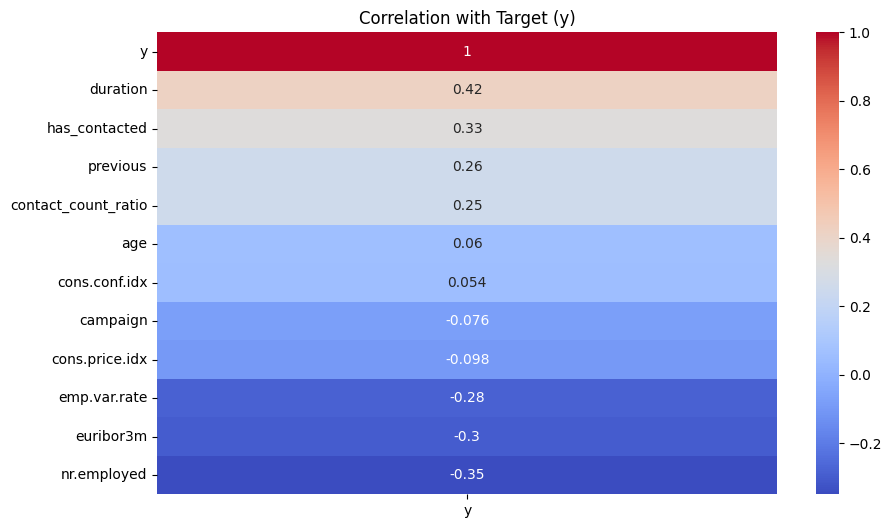

In [9]:
# Calculate and visualize correlations between numerical features and target variable

corr_matrix = df[numerical_cols].copy()
corr_matrix['y'] = df['y'].map({'yes': 1, 'no': 0})  # Encode target
corr = corr_matrix.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr[['y']].sort_values(by='y', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation with Target (y)")
plt.show()

## For nonlinear relationship of features to categorical target

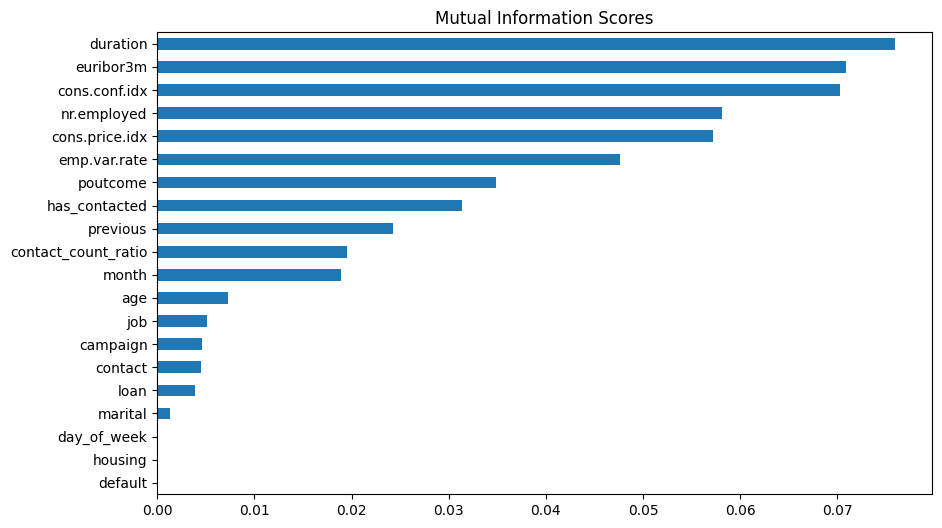

In [10]:
# Calculate and visualize mutual information scores between features and target to understand nonlinear relationships

# Encode target
y_encoded = df['y'].map({'yes': 1, 'no': 0})

# For mutual info, use only raw categorical + numerical (before dummies)
X_raw = df.drop('y', axis=1)

# Encode categoricals using LabelEncoder temporarily
X_encoded = X_raw.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# Compute mutual information
mi_scores = mutual_info_classif(X_encoded, y_encoded, discrete_features='auto')
mi_df = pd.Series(mi_scores, index=X_encoded.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
mi_df.head(20).plot(kind='barh')
plt.title("Mutual Information Scores")
plt.gca().invert_yaxis()
plt.show()

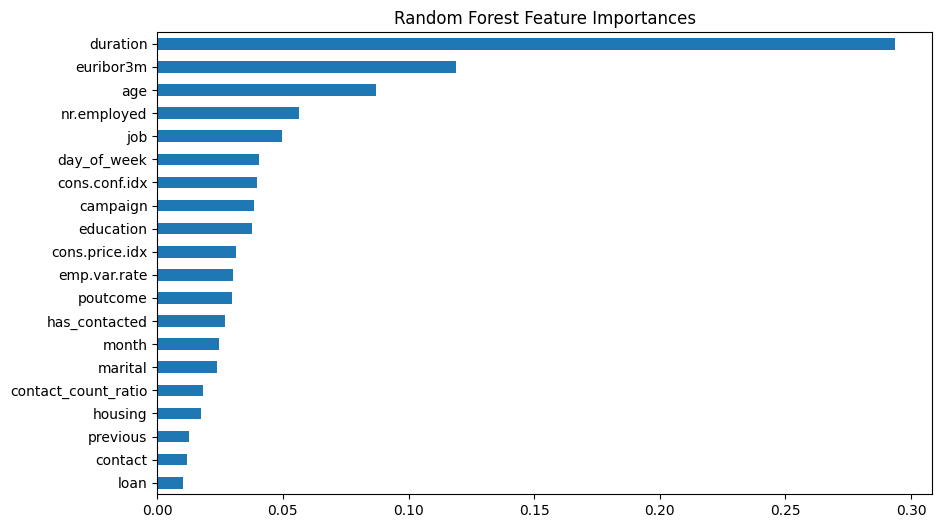

In [11]:
# Use Random Forest to calculate and visualize feature importance scores for both categorical and numerical features

# Again, encode categoricals for modeling
X_rf = X_encoded.copy()
model = RandomForestClassifier(random_state=42)
model.fit(X_rf, y_encoded)

rf_importances = pd.Series(model.feature_importances_, index=X_rf.columns).sort_values(ascending=False)

# Plot top 20
plt.figure(figsize=(10, 6))
rf_importances.head(20).plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

## checking pairwise feature relations

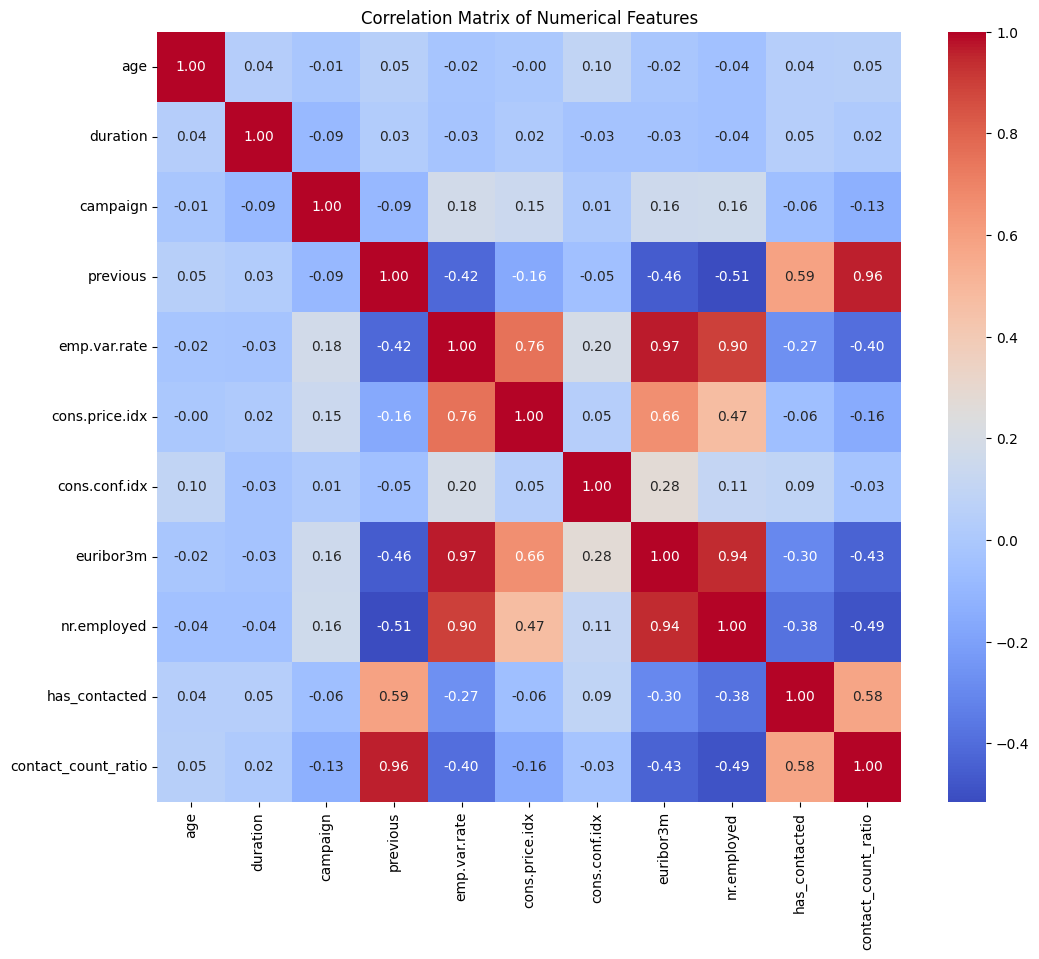

Chi-squared test for job vs marital:
Chi2: 391.41434621575326, p-value: 1.2316496234472512e-70
Chi-squared test for job vs education:
Chi2: 3305.2214139487655, p-value: 0.0
Chi-squared test for job vs default:
Chi2: 36.11687646850347, p-value: 8.037035211346857e-05
Chi-squared test for job vs housing:
Chi2: 12.836856548233788, p-value: 0.23293695692490257
Chi-squared test for job vs loan:
Chi2: 3.8779916545365385, p-value: 0.9526831625303456
Chi-squared test for job vs contact:
Chi2: 66.42811716823181, p-value: 2.158908457668733e-10
Chi-squared test for job vs month:
Chi2: 503.7123473033399, p-value: 8.498089572636172e-59
Chi-squared test for job vs day_of_week:
Chi2: 45.92122537232999, p-value: 0.2402014328169808
Chi-squared test for job vs poutcome:
Chi2: 89.3754691663204, p-value: 9.530125418230377e-11
Chi-squared test for job vs y:
Chi2: 69.65791578872116, p-value: 5.161832631204899e-11
Chi-squared test for marital vs job:
Chi2: 391.4143462157533, p-value: 1.2316496234472161e-70
Ch

poutcome,failure,nonexistent,success
y,,,
no,387,3231,50
yes,67,292,92


In [12]:
# Analyze feature relationships: correlation matrix for numerical features and chi-squared tests for categorical features

# Create a correlation matrix for numerical features
corr_matrix = df[numerical_cols].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# For categorical features, you can create contingency tables and chi-squared tests
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            contingency_table = pd.crosstab(df[col1], df[col2])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"Chi-squared test for {col1} vs {col2}:")
            print(f"Chi2: {chi2}, p-value: {p}")
            # You can further analyze the contingency table to understand the relationship
contingency_table


## histograms and boxplots

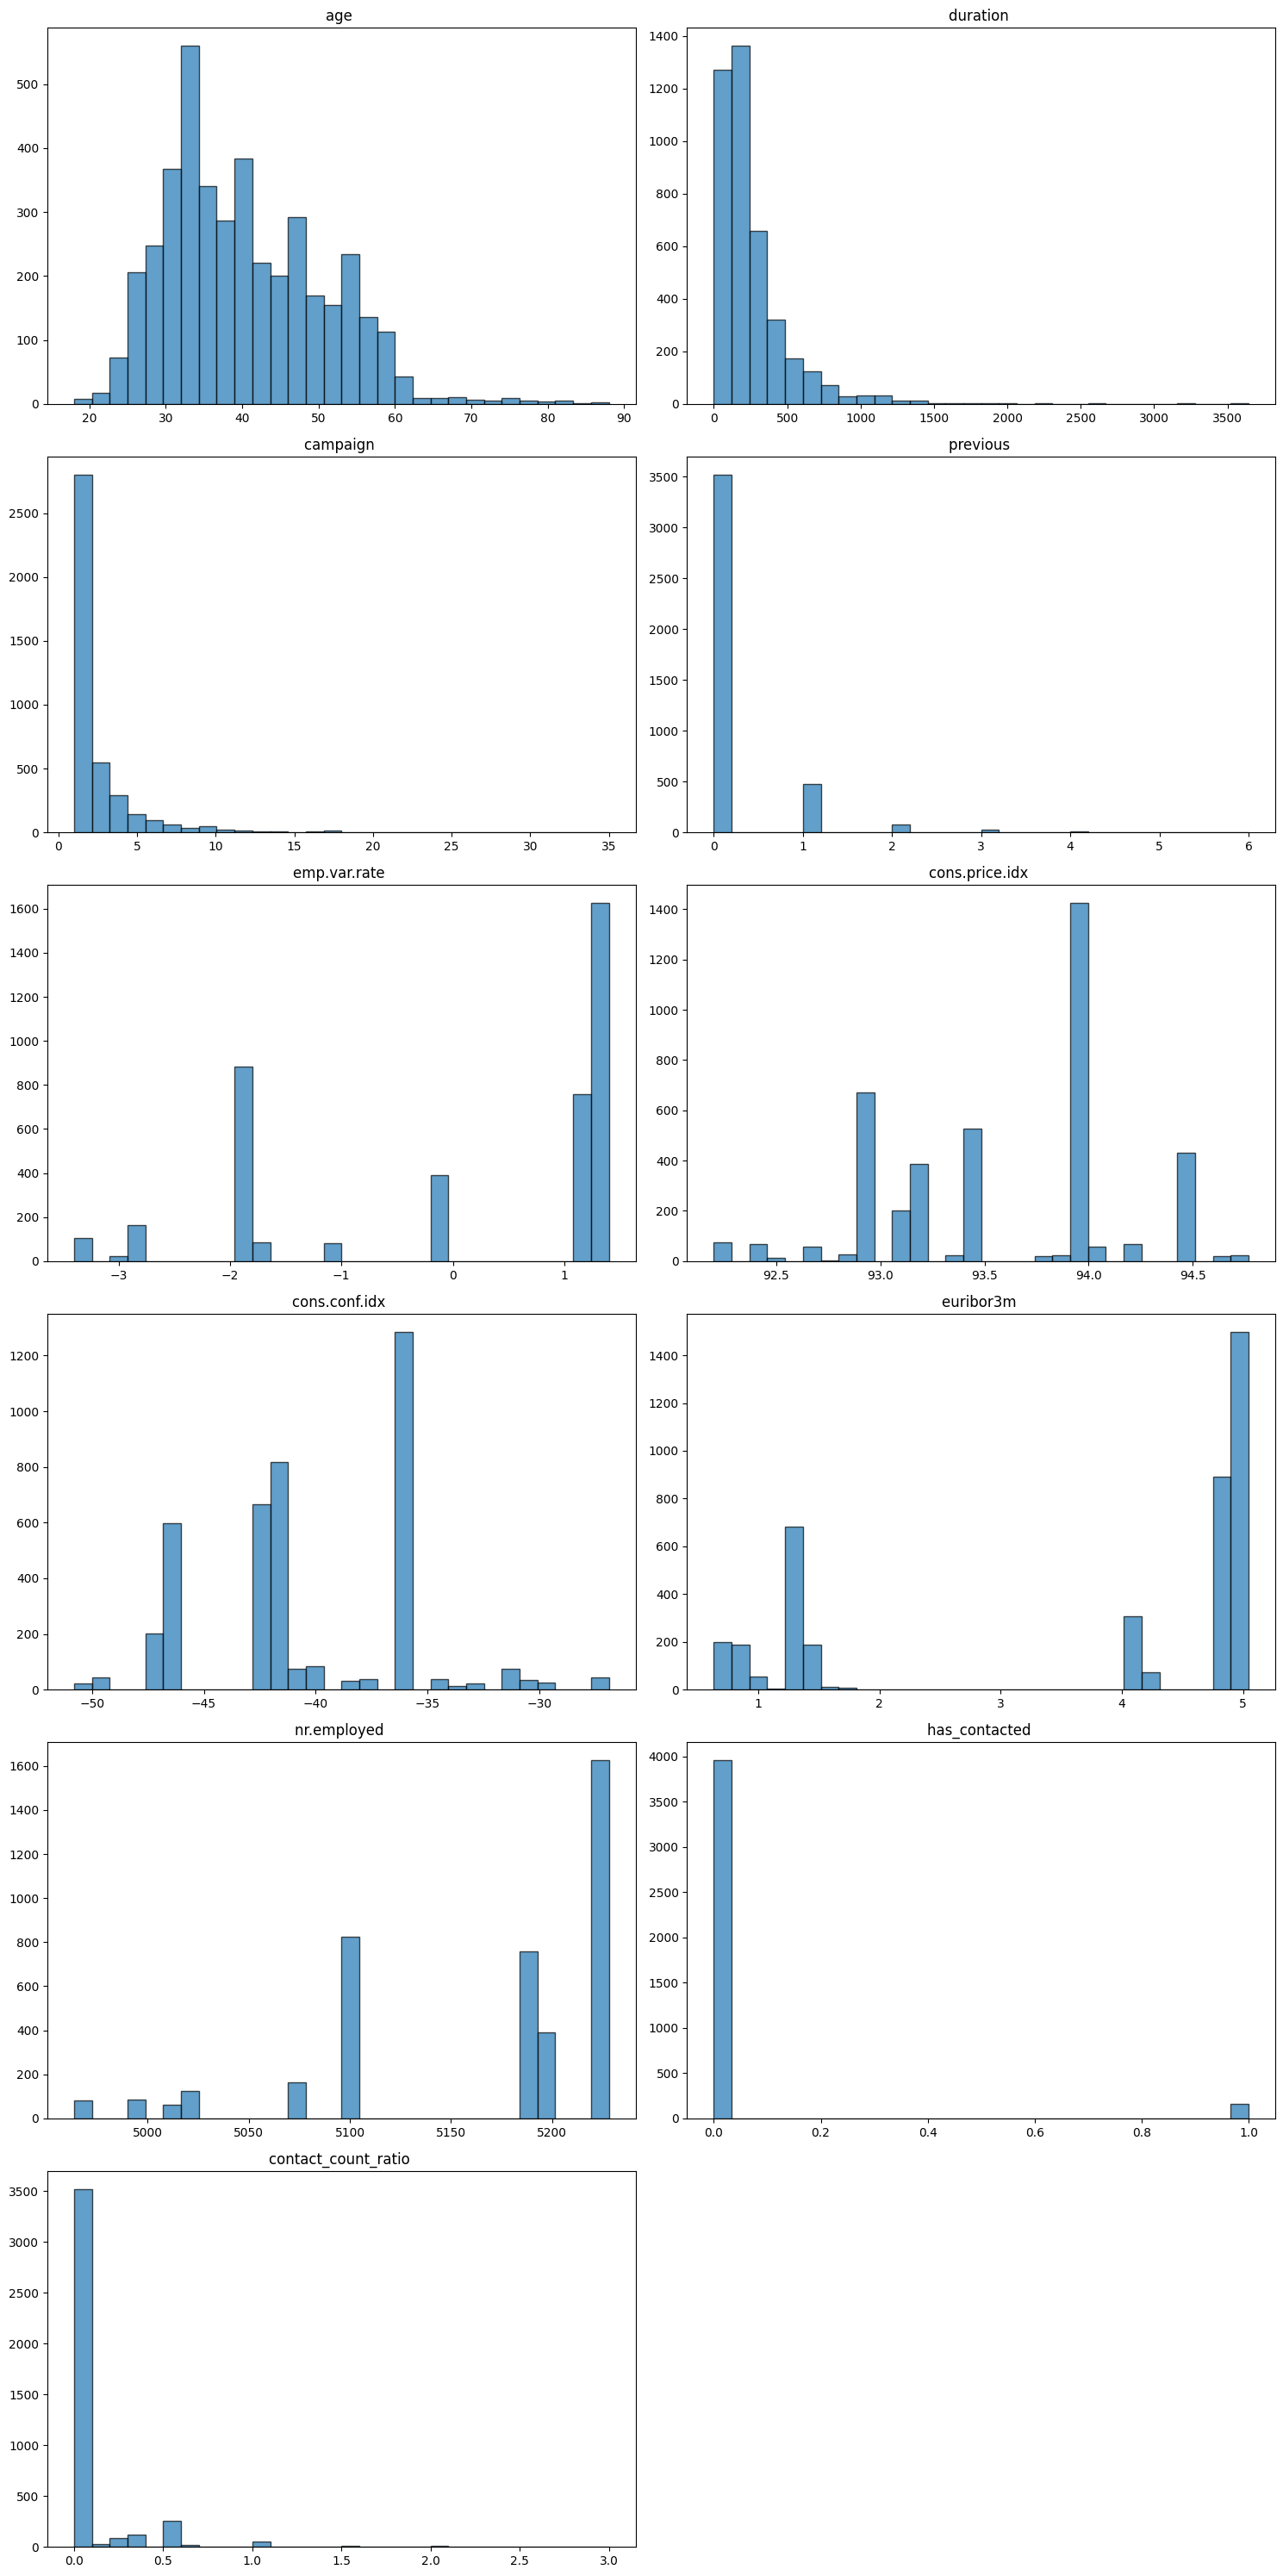

In [13]:
# Create histograms for all numerical features to visualize their distributions

# Determine the number of numerical columns
num_numerical_cols = len(numerical_cols)

# Calculate the grid size (round up to ensure enough space for all subplots)
nrows = (num_numerical_cols // 2) + (num_numerical_cols % 2)
ncols = 2

# Create the subplots with the appropriate size
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the axes array
axes = axes.flatten()

# Loop over the numerical columns and plot histograms
for i, num in enumerate(numerical_cols):
    axes[i].hist(df[num], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{num} ')

# If there are unused axes, remove them
for i in range(num_numerical_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

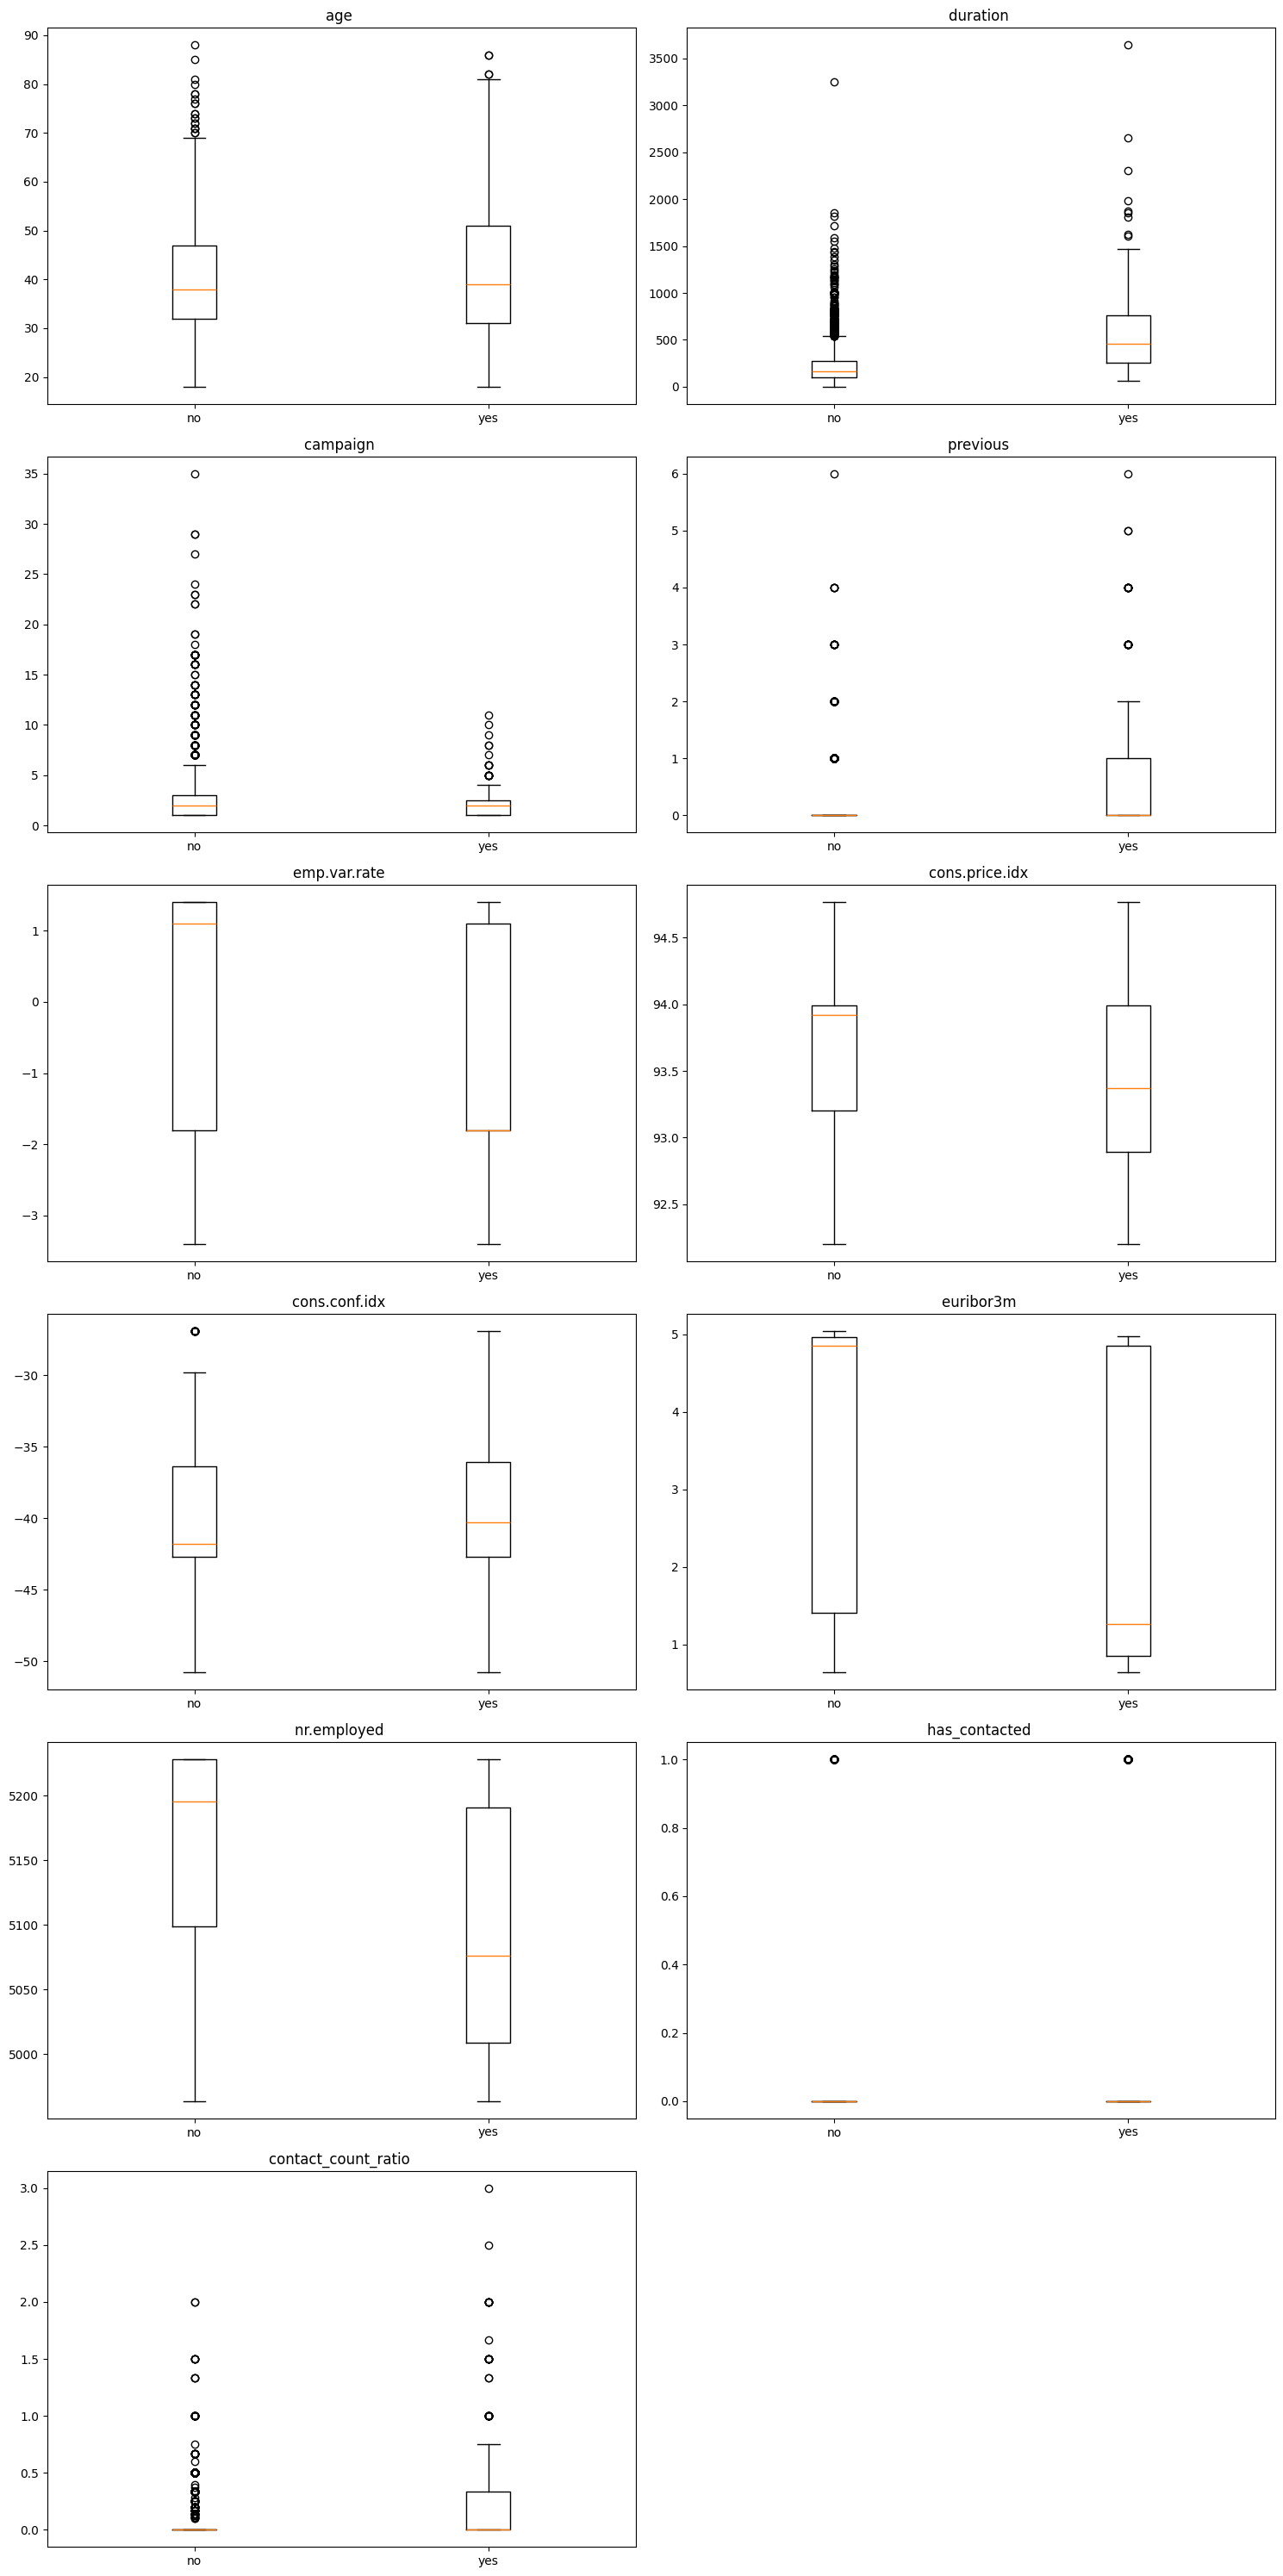

In [14]:
# Create boxplots comparing numerical features distribution between subscription outcomes (yes/no)

# Create the subplots with the appropriate size
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the axes array
axes = axes.flatten()

# Loop over the numerical columns and create boxplots
for i, num in enumerate(numerical_cols):
    axes[i].boxplot
    data = [df[df['y'] == value][num] for value in df['y'].unique()]
    axes[i].boxplot(data, labels=df['y'].unique())
    axes[i].set_title(f'{num} ')

# If there are unused axes, remove them
for i in range(num_numerical_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 3. Model selection and Pipelining

In [15]:
# Define dictionary of classification models to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM (RBF Kernel)': SVC(),             # SVC with default RBF kernel
    'XGBoost': XGBClassifier(),             # XGBoost Classifier
    'LightGBM': LGBMClassifier(),
}

In [16]:
# Define transformers for binary (yes/no), ordinal (education levels), and nominal (categorical) features
def yes_no_to_binary(df):
    return df.applymap(lambda val: 1 if val == 'yes' else 0).astype(int)

binary_transformer = FunctionTransformer(yes_no_to_binary)

ordinal_transformer = OrdinalEncoder(categories=[
    ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
])

nominal_transformer = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

In [17]:
# Define preprocessor using ColumnTransformer to apply different transformations to different feature groups
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', binary_transformer, ['default', 'housing', 'loan']),
        ('ordinal', ordinal_transformer, ['education']),
        ('nominal', nominal_transformer, ['job', 'marital', 'contact', 'month', 'day_of_week', 'poutcome'])
    ]
)

In [18]:
# Prepare target variable y and feature matrix X by encoding target and dropping target column
y = df['y'].map({'yes':1, 'no':0})
X = df.drop(columns=['y'])

In [19]:
# Split data into training (80%) and test (20%) sets, stratified by target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [20]:
# Define log transformation function for campaign and previous features
def log_transform_func(df):
    return df.assign(
        campaign=np.log1p(df['campaign']),
        previous=np.log1p(df['previous'])
    )

log_transform = FunctionTransformer(log_transform_func, validate=False)

## data imbalance check

In [21]:
# Check the class distribution (handled in preprocessing pipeline)
print(df['y'].value_counts())

y
no     3668
yes     451
Name: count, dtype: int64


## model fit

In [22]:
# Train and evaluate each model in the pipeline with SMOTE preprocessing
for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    
    # Create pipeline with preprocessor, SMOTE for class imbalance, and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Apply feature preprocessing
        ('smote', SMOTE(random_state=42)),  # Handle class imbalance
        ('classifier', model)  # The actual model
    ])

    # Fit the model on training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on test set
    y_pred = pipeline.predict(X_test)

    # Print model parameters for analysis
    print("Model parameters:")
    print(pipeline.named_steps['classifier'].get_params())

    # Calculate and print accuracy score
    score = pipeline.score(X_test, y_test)
    print("Model score:", score)



Model: Logistic Regression
Model parameters:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Model score: 0.7669902912621359

Model: Random Forest
Model parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Model score: 0.8810679611650486

Model: SVM (RBF Kernel)
Model parameters:
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_sh

# 4. Hyperparameter Tuning

In [23]:
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1],
        'classifier__solver': ['liblinear'],
        'classifier__penalty': ['l2'],
        'classifier__max_iter': [100]
    },
    'Random Forest': {
        'classifier__n_estimators': [100],
        'classifier__max_depth': [10, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__max_features': ['sqrt']
    },
    'SVM (RBF Kernel)': {
        'classifier__C': [1, 10],
        'classifier__gamma': ['scale'],
        'classifier__kernel': ['rbf']
    },
    'XGBoost': {
        'classifier__n_estimators': [100],
        'classifier__max_depth': [3, 6],
        'classifier__learning_rate': [0.1],
        'classifier__subsample': [1.0]
    },
    'LightGBM': {
        'classifier__n_estimators': [100],
        'classifier__learning_rate': [0.1],
        'classifier__num_leaves': [31, 50],
        'classifier__max_depth': [-1]
    },
}


In [24]:
# Perform grid search cross validation on each model and collect performance metrics
results = {}

for name, model in models.items():
    # Create stratified k-fold cross validator
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Define pipeline with preprocessing steps and classifier
    pipeline = Pipeline(steps=[
        ('log_transform', log_transform),
        ('preprocessor', preprocessor), 
        ('smote', SMOTE(random_state=42)),  # Handle class imbalance
        ('classifier', model)
    ])

    # Perform grid search with cross validation
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get predictions on test set
    y_pred = grid_search.predict(X_test)
    
    # Store all evaluation metrics
    results[name] = {
        'pipeline': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),  # True positive rate
        'recall': recall_score(y_test, y_pred),        # Sensitivity
        'f1': f1_score(y_test, y_pred),               # Harmonic mean of precision & recall
        'roc_auc': roc_auc_score(y_test, y_pred),     # Area under ROC curve
        'y_pred': y_pred
    }
    
    print(f'{name}: {results[name]}')

# Display detailed results for each model
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print("\n")

/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use

Logistic Regression: {'pipeline': Pipeline(steps=[('log_transform',
                 FunctionTransformer(func=<function log_transform_func at 0x156140dc0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x15629ad30>),
                                                  ['default', 'housing',
                                                   'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                        

/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use

Random Forest: {'pipeline': Pipeline(steps=[('log_transform',
                 FunctionTransformer(func=<function log_transform_func at 0x156140dc0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x15629ad30>),
                                                  ['default', 'housing',
                                                   'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                              

/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/var/folders/6y/jc_p

SVM (RBF Kernel): {'pipeline': Pipeline(steps=[('log_transform',
                 FunctionTransformer(func=<function log_transform_func at 0x156140dc0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x15629ad30>),
                                                  ['default', 'housing',
                                                   'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                           

/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use

XGBoost: {'pipeline': Pipeline(steps=[('log_transform',
                 FunctionTransformer(func=<function log_transform_func at 0x156140dc0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x15629ad30>),
                                                  ['default', 'housing',
                                                   'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                              'high.

/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/env

[LightGBM] [Info] Number of positive: 2347, number of negative: 2347
[LightGBM] [Info] Number of positive: 2347, number of negative: 2347
[LightGBM] [Info] Number of positive: 2347, number of negative: 2347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3971
[LightGBM] [Info] Number of data points in the train set: 4696, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2348, number of negative: 2348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 4694, number of used features: 31
[Ligh

/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecat

[LightGBM] [Info] Number of positive: 2347, number of negative: 2347
[LightGBM] [Info] Number of positive: 2347, number of negative: 2347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3639
[LightGBM] [Info] Number of data points in the train set: 4694, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3662
[LightGBM] [Info] Number of data points in the train set: 4694, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_87650/3289072058.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/utils/valid

[LightGBM] [Info] Number of positive: 2934, number of negative: 2934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4615
[LightGBM] [Info] Number of data points in the train set: 5868, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM: {'pipeline': Pipeline(steps=[('log_transform',
                 FunctionTransformer(func=<function log_transform_func at 0x156140dc0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x15629ad30>),
                                                  ['default', 'housing',
                                                   'loan']),
      

# 5. Evaluation

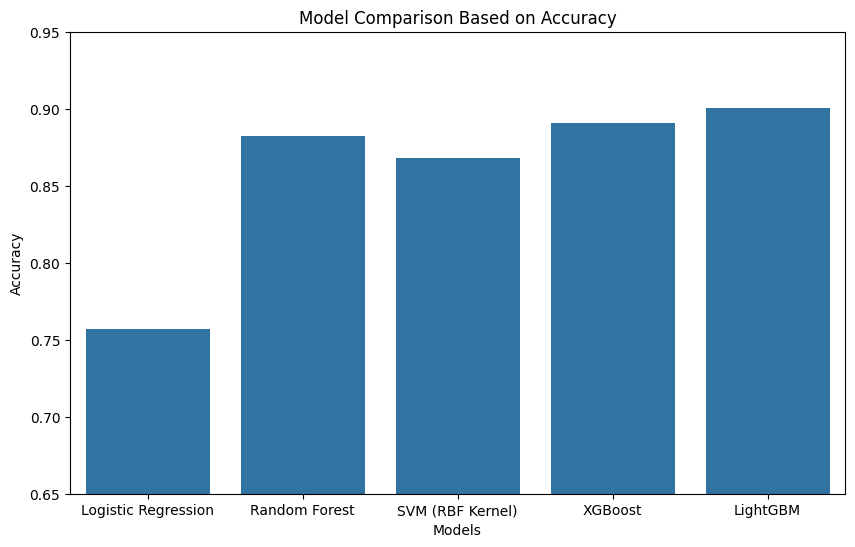

In [25]:
# Extract accuracy values from the results dictionary

accuracies = [metrics['accuracy'] for name, metrics in results.items()]
model_names = list(results.keys())  # Use actual model names

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Comparison Based on Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.65, 0.95)
plt.show()

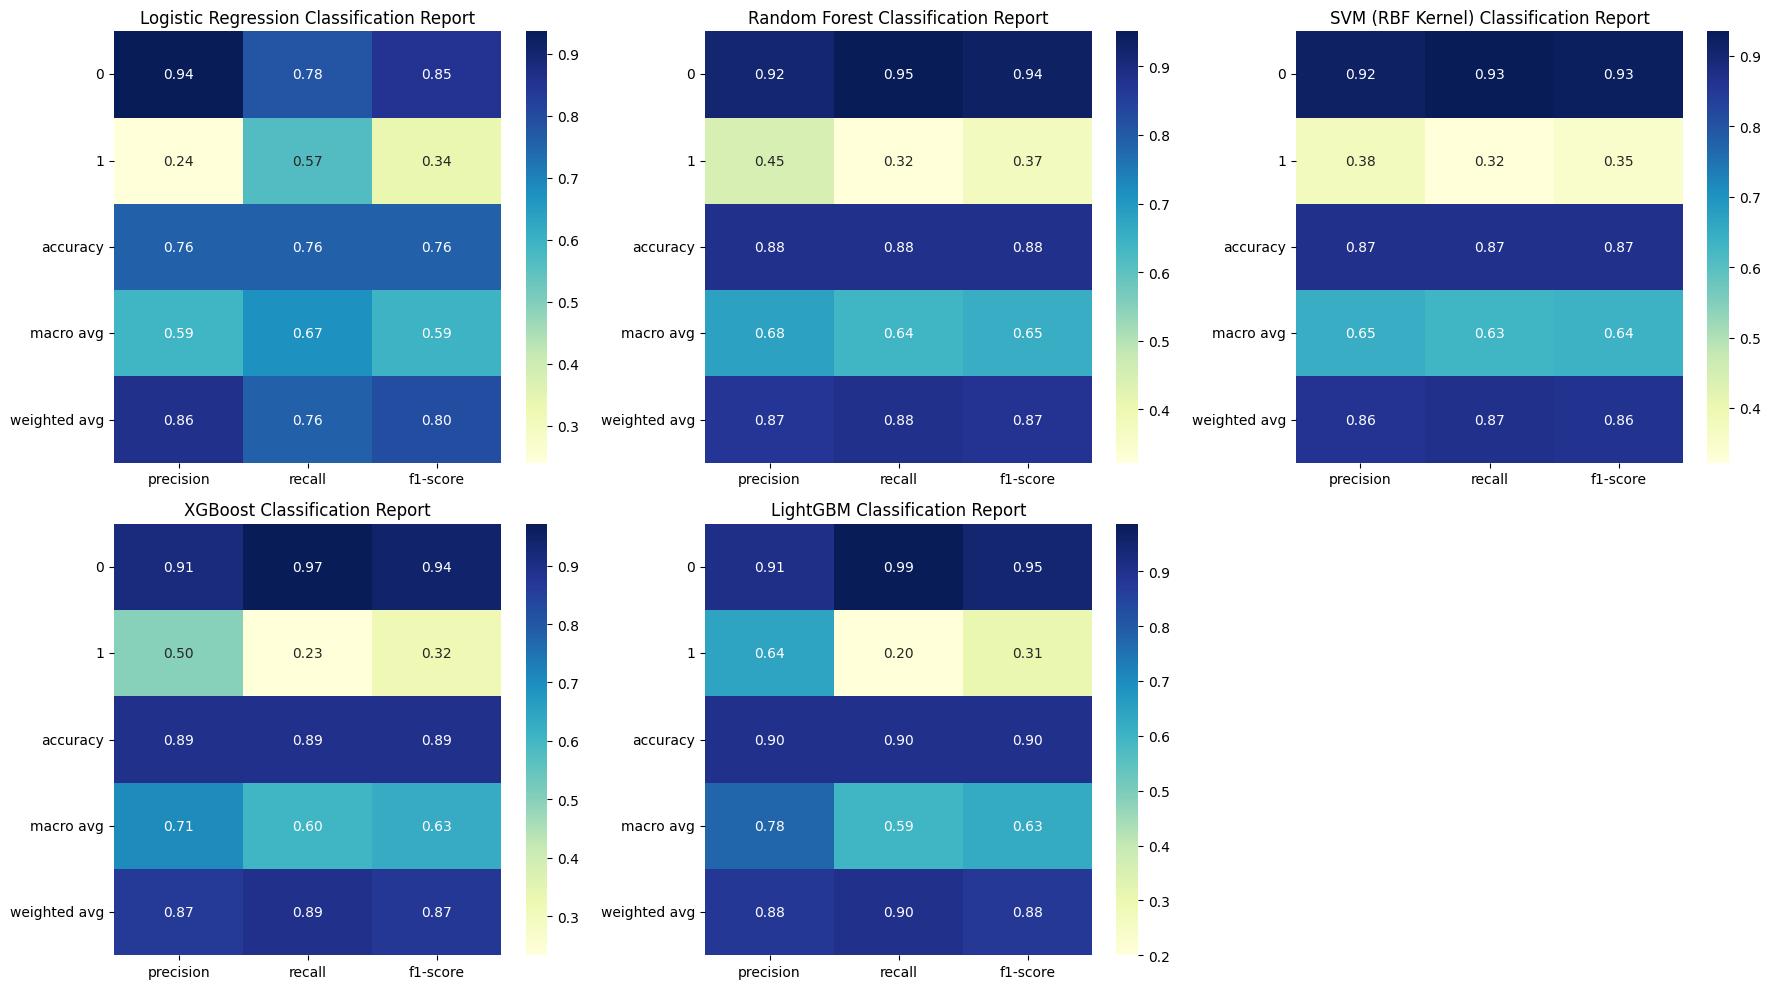

In [26]:
# Create heatmaps showing classification metrics for each model

num_models = len(results)
cols = 3  # Number of columns in subplot grid
rows = math.ceil(num_models / cols)

plt.figure(figsize=(6 * cols, 5 * rows))

for idx, (name, metrics) in enumerate(results.items(), 1):
    y_pred = metrics['y_pred']
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).iloc[:-1, :].T  # Exclude 'accuracy' row

    plt.subplot(rows, cols, idx)
    sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f'{name} Classification Report')

plt.tight_layout()
plt.show()


In [27]:
# Find the model with the best accuracy

best_model_name = max(results, key=lambda name: results[name]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Best Params: {results[best_model_name]['best_params']}")


Best Model: LightGBM
Accuracy: 0.9005
Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': -1, 'classifier__n_estimators': 100, 'classifier__num_leaves': 31}


# 6. Deployment

In [28]:
# Save the best model to a pickle file for deployment
best_pipeline = results[best_model_name]['pipeline']

joblib.dump(best_pipeline, 'best_model.pkl')

['best_model.pkl']

In [29]:
# Save test data to use it in app.py
X_test.to_csv('X_test.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)